# Step 1: Read the economy news from a RSS feed (i.e. CNBC)

In [136]:
import feedparser
import HTMLParser as parser
import re
from time import mktime
from datetime import datetime
d = feedparser.parse('http://www.cnbc.com/id/10000664/device/rss/rss.html')

news_title = []
news_date = []
news_text = []
for entry in d.entries:
    news_title.append(entry.title)
    dt = str(datetime.fromtimestamp(mktime(entry.published_parsed)))
    dt = dt[0]+dt[1]+dt[2]+dt[3]+dt[5]+dt[6]+dt[8]+dt[9]
    news_date.append(dt)
    news = entry.summary
    text = re.sub('<[^<]+?>', '', entry.summary).strip()
    text = text.encode('utf-8')
    news_text.append(text)
    print(text)

Sears, which has been shuttering stores, announced more steps to right its ship, USA Today reports.
Klaus Kleinfeld has resigned from Morgan Stanley&#039;s board and will not stand for election at its annual meeting.
A Blackstone executive criticized a Citigroup analyst during the asset manager&#039;s first quarter earnings call Thursday.
The moves will target two areas — &quot;living wills&quot; and the designation of what institutions will come under SIFI rules.
This software-based process will supplement the bank&#039;s annual review process with more frequently occurring check-ins, the company said.
Fed&#039;s Stanley Fischer discusses his views on the market and deregulation in an exclusive wide-ranging interview Friday on CNBC&#039;s &quot;Squawk on the Street.&quot;
Fischer attributed much of the slowness both in the economy and the inflation rate to seasonal factors.
Minneapolis Fed President Neel Kashkari said that immigration has been a key driver of growth, and without it th

# Parse the news' content, using Microsoft Cognitive Services

In [137]:
import urllib2
import urllib
import sys
import base64
import json
from collections import OrderedDict
import simplejson as sj

# Azure portal URL.
base_url = 'https://westus.api.cognitive.microsoft.com/'
account_key = '16f9c7afa4684cee89f276d4ac3668f7'
headers = {'Content-Type':'application/json', 'Ocp-Apim-Subscription-Key':account_key}

# Input data information
sentiment_values = []
for elem in news_text:
    data = []
    data.append(OrderedDict())
    data[0]['language'] = 'en'
    data[0]['id'] = '1'
    data[0]['text'] = elem
    data_parent = OrderedDict()
    data_parent["documents"] = data

    input_texts = sj.dumps(data_parent)
    #print(input_texts)

    # Detect sentiment.
    batch_sentiment_url = base_url + 'text/analytics/v2.0/sentiment'
    req = urllib2.Request(batch_sentiment_url, input_texts, headers) 
    response = urllib2.urlopen(req)
    result = response.read()
    obj = json.loads(result)
    for sentiment_analysis in obj['documents']:
        print('Text: ' + str(elem))
        print('Score: ' + str(sentiment_analysis['score']))
        sentiment_values.append(sentiment_analysis['score'])
        print('\n')

Text: Sears, which has been shuttering stores, announced more steps to right its ship, USA Today reports.
Score: 0.5


Text: Klaus Kleinfeld has resigned from Morgan Stanley&#039;s board and will not stand for election at its annual meeting.
Score: 0.133399733367


Text: A Blackstone executive criticized a Citigroup analyst during the asset manager&#039;s first quarter earnings call Thursday.
Score: 0.83865520198


Text: The moves will target two areas — &quot;living wills&quot; and the designation of what institutions will come under SIFI rules.
Score: 0.5


Text: This software-based process will supplement the bank&#039;s annual review process with more frequently occurring check-ins, the company said.
Score: 0.5


Text: Fed&#039;s Stanley Fischer discusses his views on the market and deregulation in an exclusive wide-ranging interview Friday on CNBC&#039;s &quot;Squawk on the Street.&quot;
Score: 0.867714777199


Text: Fischer attributed much of the slowness both in the economy and 

# Plot the results (how does the sentiment evolve over time?)

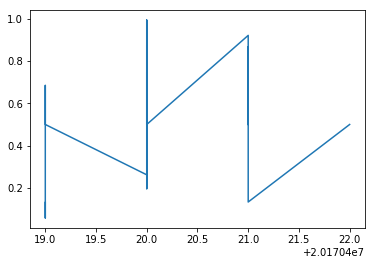

In [138]:
import matplotlib
import matplotlib.pyplot as plt
plt.plot(news_date, sentiment_values)
plt.show()

# Step 2: Extract stock information (i.e. from Markitondemand API)

#### As data from a whole stock market index is not available, data from Google value in Nasdaq (GOOG) is used 

In [139]:
import requests
import simplejson as sj
from collections import OrderedDict

import urllib
url = 'http://dev.markitondemand.com/MODApis/Api/v2/InteractiveChart/json?parameters='
data = []
data.append(OrderedDict())
data[0]["Normalized"] = "false"
data[0]["NumberOfDays"] = 4
data[0]["DataPeriod"] = "Day"
data[0]["Elements"] = []
data[0]["Elements"].append(OrderedDict())
data[0]["Elements"][0]["Symbol"] = "GOOG"
data[0]["Elements"][0]["Type"] = "price"
data[0]["Elements"][0]["Params"] = ['c']

json_data = sj.dumps(data)
json_data_len = len(json_data)
json_data = json_data[1:json_data_len-1]

print(json_data)
url = url+json_data
r = requests.get(url)
parse = sj.loads(r.text)

dates = parse['Dates']

elements = sj.loads(sj.dumps(parse['Elements']))
values = elements[0]['DataSeries']['close']['values']

i = 1
if (len(dates) == len(values)):
    dates_vec = []
    values_vec = []
    for e in dates:
        i += 1
        #dates_vec.append(i)
        dates_vec.append(e[0]+e[1]+e[2]+e[3]+e[5]+e[6]+e[8]+e[9])
    for e in values:
        values_vec.append(e)

{"Normalized": "false", "NumberOfDays": 4, "DataPeriod": "Day", "Elements": [{"Symbol": "GOOG", "Type": "price", "Params": ["c"]}]}


# Plot the results (how does the stock market evolve over time?)

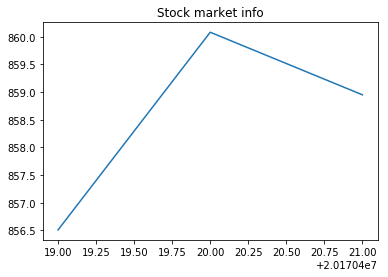

In [140]:
import matplotlib
import matplotlib.pyplot as plt
plt.plot(dates_vec, values_vec)
plt.title('Stock market info')
plt.show()

# Step 3: Cleanse results (first sample correlation)

In [158]:
import numpy
news_date2 = list(reversed(news_date))
i = 0
indexes_array = []
for element in dates_vec:
    print(element)
    indexes_array.append(news_date2.index(element))

print('\n')    

cnt = 0
final_sent_arr = []

i = 0
while i < len(indexes_array):
    if (i == len(indexes_array)-1):
        nou_arr = sentiment_values[indexes_array[i]:len(news_date2)]
    else:
        nou_arr = sentiment_values[indexes_array[i]:indexes_array[i+1]]
    print(nou_arr)
    final_sent_arr.append(numpy.mean(nou_arr))
    i += 1

print('\n')
for elt in final_sent_arr:
    print(elt)

20170419
20170420
20170421


[0.5, 0.13339973336692, 0.838655201980215, 0.5, 0.5]
[0.867714777198795, 0.5, 0.5, 0.5, 0.5, 0.921334161958416, 0.5, 0.874172758053192, 0.5, 0.5, 0.746936799005045, 0.266994373947715, 0.992944743087147, 0.981044096799288]
[0.196151307553089, 0.5, 0.822276162444183, 0.980366014740147, 0.992324717729719, 0.261940529208335, 0.5, 0.684624434313836, 0.5, 0.0580879086444872, 0.13123212809081]


0.494410987069
0.653652979289
0.511545745702


# Step 4: Apply a simple TensorFlow model

### We use a quadratic model (function with the form of f(x)=a*x²+b*x+c) in order to best approximate the values that the market takes as a function of the sentiments emitted by the economic news. What TF will do is determine the values of the constants a, b, and c.

In [160]:
import tensorflow as tf
sess = tf.Session()
a = tf.Variable([.0], tf.float32)
b = tf.Variable([.0], tf.float32)
c = tf.Variable([.0], tf.float32)
x = tf.placeholder(tf.float32)
tf_model = a*x*x + b*x + c
init = tf.global_variables_initializer()


y = tf.placeholder(tf.float32)
squared_deltas = tf.square(tf_model - y)
loss = tf.reduce_sum(squared_deltas)

optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

sess.run(init)
for i in range(100000):
    sess.run(train, {x: final_sent_arr, y: values_vec})
    
print sess.run([a, b, c])

[array([-107.76254272], dtype=float32), array([ 141.12240601], dtype=float32), array([ 813.97241211], dtype=float32)]


# Step 5: Use the model produced by TensorFlow to simulate the market

In [185]:
#Let's suppose two different scenarios, with news trasmitting bad and good vibes
title_bad = 'Worried economists ask the Government to take action to prevent a real estate bubble'
title_good = 'The ECB releases new optimistic predictions showing higher GDP growth'

In [186]:
import urllib2
import urllib
import sys
import base64
import json
from collections import OrderedDict
import simplejson as sj

# Azure portal URL.
base_url = 'https://westus.api.cognitive.microsoft.com/'
account_key = '16f9c7afa4684cee89f276d4ac3668f7'
headers = {'Content-Type':'application/json', 'Ocp-Apim-Subscription-Key':account_key}

# Input data information 1
data = []
data.append(OrderedDict())
data[0]['language'] = 'en'
data[0]['id'] = '1'
data[0]['text'] = title_bad
data_parent = OrderedDict()
data_parent["documents"] = data

input_texts = sj.dumps(data_parent)
print(input_texts)

# Detect sentiment for news 1
batch_sentiment_url = base_url + 'text/analytics/v2.0/sentiment'
req = urllib2.Request(batch_sentiment_url, input_texts, headers) 
response = urllib2.urlopen(req)
result = response.read()
obj = json.loads(result)
for sentiment_analysis in obj['documents']:
    print('Score: ' + str(sentiment_analysis['score']))
    sentiment_values.append(sentiment_analysis['score'])
    print('\n')

# Input data information 2
data[0]['text'] = title_good

input_texts = sj.dumps(data_parent)
print(input_texts)

# Detect sentiment for news 2
batch_sentiment_url = base_url + 'text/analytics/v2.0/sentiment'
req = urllib2.Request(batch_sentiment_url, input_texts, headers) 
response = urllib2.urlopen(req)
result = response.read()
obj = json.loads(result)
for sentiment_analysis in obj['documents']:
    print('Score: ' + str(sentiment_analysis['score']))
    sentiment_values.append(sentiment_analysis['score'])
    print('\n')

{"documents": [{"language": "en", "id": "1", "text": "Worried economists ask the Government to take action to prevent a real estate bubble"}]}
Score: 0.130245364287


{"documents": [{"language": "en", "id": "1", "text": "The ECB releases new optimistic predictions showing higher GDP growth"}]}
Score: 0.971520386398




#### As we can see, and as expected, the second news is detected as more positive than the first one. Now, using these data:

In [192]:
a = -107.76254272
b = 141.12240601
c = 813.97241211

x1 = 0.130245364287
x2 = 0.971520386398

y1 = a*x1*x1 + b*x1 + c
y2 = a*x2*x2 + b*x2 + c

print(y1)
print(y2)

830.52488315
849.363830014


#### And, of course, this results in a higher value of the Google shares for the second case.